In [1]:
import torch 
import matplotlib.pyplot as plt

from EWOthello.mingpt.model import GPTConfig,  GPTforProbeIA, GPTforProbeIA_ModV1
from EWOthello.data.othello import * # permit_reverse lives here and takes board integer to board's tile string
from EWOthello.mingpt.dataset import CharDataset
from EWOthello.mingpt.probe_model import BatteryProbeClassificationTwoLayer

from EWOthello.mingpt.utils import  intervene

/home/deanhazineh/anaconda3/envs/emergent_world/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load a pretrained probe. In the paper, they introduce the idea that they if they intervene in a layer, they have to intervene and modify all subsequent layers. For this reason, we need to load a set of probes if we stick to their implementation strategy. In the future, we might deviate from this but for now let us walk through their implementation

In [2]:
probes = {} # We need the pre-trained probes for the layer we want and all layers after it according to their theory
layer_s = 4
layer_e = 9
for layer in range(layer_s, layer_e):
    p = BatteryProbeClassificationTwoLayer(torch.cuda.current_device(), probe_class=3, num_task=64, mid_dim=128)
    load_res = p.load_state_dict(torch.load(f"../EWOthello/ckpts/battery_othello/state_tl128/layer{layer}/checkpoint.ckpt"))
    p.eval()
    probes[layer] = p

#probe = BatteryProbeClassificationTwoLayer(torch.cuda.current_device(), probe_class=3, num_task=64, mid_dim=128)
#checkpoint_path = "../EWOthello/ckpts/battery_othello/state_tl128/layer3/checkpoint.ckpt"
#load_res = probe.load_state_dict(torch.load(checkpoint_path))

Load a pre-trained model.

In [3]:
othello = get(ood_perc=0., data_root=None, wthor=False, ood_num=1)
train_dataset = CharDataset(othello)

mconf = GPTConfig(61, 59, n_layer=8, n_head=8, n_embd=512)
model = GPTforProbeIA_ModV1(mconf)
#model = GPTforProbeIA(mconf, probe_layer=3)
load_res = model.load_state_dict(torch.load("../EWOthello/ckpts/gpt_synthetic.ckpt"))

if torch.cuda.is_available():
    device = torch.cuda.current_device()
    model = model.to(device)
_ = model.eval()

100%|██████████| 1/1 [00:00<00:00, 52.81it/s]


Dataset created has 1 sequences, 61 unique words.


Load a game from the intervention benchmark

In [4]:
# We are loading completion which is a small sequence of game moves at the start of a game to probe
with open("../KLiScripts/intervention_benchmark.pkl", "rb") as input_file:
    dataset = pickle.load(input_file)
case_id = 777
wtd = {
    "intervention_position": permit_reverse(dataset[case_id]["pos_int"]), 
    "intervention_from": dataset[case_id]["ori_color"], 
    "intervention_to": 2 - dataset[case_id]["ori_color"], 
}
completion = dataset[case_id]["history"]
print(completion)
print(wtd)

# Then view partial gameplay of the benchmark
ab = OthelloBoardState()
ab.update(completion, prt=True)

# Cast the current gaem sequence to a model input vector
partial_game = torch.tensor([train_dataset.stoi[s] for s in completion], dtype=torch.long).to(device)

[37, 29, 18, 42, 19]
{'intervention_position': 'e6', 'intervention_from': 2.0, 'intervention_to': 0.0}
--------------------
[]
a                
b                
c                
d       O X      
e       X O      
f                
g                
h                
  1 2 3 4 5 6 7 8
--------------------
--------------------
['e6']
a                
b                
c                
d       O X      
e       X X X    
f                
g                
h                
  1 2 3 4 5 6 7 8
--------------------
--------------------
['e6', 'd6']
a                
b                
c                
d       O O O    
e       X X X    
f                
g                
h                
  1 2 3 4 5 6 7 8
--------------------
--------------------
['e6', 'd6', 'c3']
a                
b                
c     X          
d       X O O    
e       X X X    
f                
g                
h                
  1 2 3 4 5 6 7 8
--------------------
--------------------
['e6', 'd6', 'c3',

In [5]:
pre_intv_valids = [permit_reverse(_) for _ in ab.get_valid_moves()]
pre_intv_valids

['b4', 'c6', 'd3', 'e7', 'f4', 'f6']

torch.Size([64])


<Axes: >

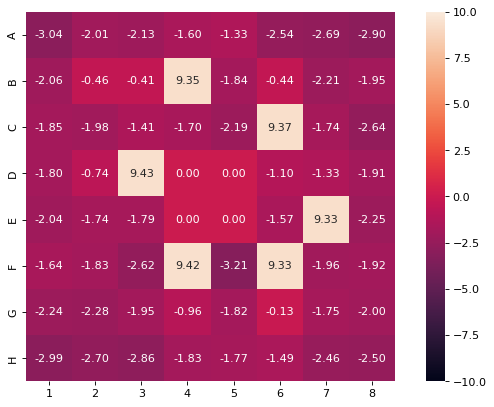

In [6]:
# Get the model logits or probabilities over the whole board for the next move

pre_intv_pred, _ = model(partial_game[None, :])  # [B, T, Vocab_size]
pre_intv_pred = pre_intv_pred[0, -1, 1:]
padding = torch.zeros(2).cuda() # Add in center two tiles with zero padding because output skips over them
pre_intv_pred = torch.cat([pre_intv_pred[:27], padding, pre_intv_pred[27:33], padding, pre_intv_pred[33:]], dim=0)
print(pre_intv_pred.shape)
#pre_intv_pred = torch.softmax(pre_intv_pred, dim=0)  # keep logits

fig=plt.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k')
vv = 10
gems = {"pre": pre_intv_pred.detach().cpu().numpy().reshape(8, 8)}
sns.heatmap(pre_intv_pred.detach().cpu().numpy().reshape(8, 8), vmin=-vv, vmax=vv, 
            yticklabels=list("ABCDEFGH"), xticklabels=list(range(1,9)), square=True, 
            annot=True, fmt=".2f")

Now intervene on the board 

In [7]:
htd = {"lr": 1e-3, "steps": 1000, "reg_strg": 0.2}
# initial probing is starting at layer_s defined above

# 0=White; 1=Blank; 2=Black
for square in [permit_reverse(_) for _ in range(64)]: # Iterate over tile string name
    wtd["intervention_position"] = square
    move = permit(wtd["intervention_position"]) # convert tile name to move integer
    
    # Define intervention action by flipping that tile if there is a piece there
    r, c = move // 8, move % 8
    wtd["intervention_from"] = ab.state[r, c] + 1
    wtd["intervention_to"] = 2 - wtd["intervention_from"]
    print(wtd)
    
    # Get the layer activation and use probe to get the board state
    this_probe = probes[layer_s]
    whole_mid_act = model.forward_1st_stage(layer_s, partial_game[None, :]) 
    mid_act = whole_mid_act[0, -1]    
    pre_intv_logits = this_probe(mid_act[None, :])[0].squeeze(0)  # [64, 3]
    labels_pre_intv = pre_intv_logits.detach().argmax(dim=-1)

    # Intervene to get a new activation which provides the new board state
    new_mid_act = intervene(this_probe, mid_act.clone(), labels_pre_intv, wtd, htd, plot=True)
    # swap the mid activations then propagate updates to downstream layers
    whole_mid_act[0, -1] = new_mid_act

    for i, layer in enumerate(range(layer_s, layer_e - 1)):  # 4, 5, 6, 7, indices of the layers to be passed
        whole_mid_act = model.forward_2nd_stage(whole_mid_act, layer, layer+1)[0]  # [1, T, F=512]

        # intervene the output of the features freshly out
        mid_act = whole_mid_act[0, -1]
        this_probe = probes[layer+1]
        pre_intv_logits = this_probe(mid_act[None, :])[0].squeeze(0)  # [64, 3]
        labels_pre_intv = pre_intv_logits.detach().argmax(dim=-1)
        
        new_mid_act = intervene(this_probe, mid_act.clone(), labels_pre_intv, wtd, htd, plot=True)
        whole_mid_act[0, -1] = new_mid_act

    tb_resumed = whole_mid_act
    post_intv_pred, _ = model.predict(tb_resumed)
    post_intv_pred = post_intv_pred[0, -1, 1:]
    post_intv_pred = torch.cat([post_intv_pred[:27], padding, post_intv_pred[27:33], padding, post_intv_pred[33:]], dim=0)
    if 0:
        gems[square] = torch.softmax(post_intv_pred, dim=0).detach().cpu().numpy().reshape(8, 8)
    else:   
        gems[square] = post_intv_pred.detach().cpu().numpy().reshape(8, 8)

{'intervention_position': 'a1', 'intervention_from': 1.0, 'intervention_to': 1.0}
a1 Sucessfully intervened!
a1 Sucessfully intervened!
a1 Sucessfully intervened!
a1 Sucessfully intervened!
a1 Sucessfully intervened!
{'intervention_position': 'a2', 'intervention_from': 1.0, 'intervention_to': 1.0}
a2 Sucessfully intervened!
a2 Sucessfully intervened!
a2 Sucessfully intervened!
a2 Sucessfully intervened!
a2 Sucessfully intervened!
{'intervention_position': 'a3', 'intervention_from': 1.0, 'intervention_to': 1.0}
a3 Sucessfully intervened!
a3 Sucessfully intervened!
a3 Sucessfully intervened!
a3 Sucessfully intervened!
a3 Sucessfully intervened!
{'intervention_position': 'a4', 'intervention_from': 1.0, 'intervention_to': 1.0}
a4 Sucessfully intervened!
a4 Sucessfully intervened!
a4 Sucessfully intervened!
a4 Sucessfully intervened!
a4 Sucessfully intervened!
{'intervention_position': 'a5', 'intervention_from': 1.0, 'intervention_to': 1.0}
a5 Sucessfully intervened!
a5 Sucessfully interven

Now we may plot the intervention boards via latent-saliency maps. We look at the set of moves that were previously legal and see how a flip at each tile location changes that moves logits

In [8]:
print(gems.keys()) # We added the post intervention game boards to the gems dict, indexed by the tile location

dict_keys(['pre', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'e1', 'e2', 'e3', 'e4', 'e5', 'e6', 'e7', 'e8', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'g1', 'g2', 'g3', 'g4', 'g5', 'g6', 'g7', 'g8', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8'])


In [14]:
tbu = pre_intv_valids
total = len(tbu)
rows = int(np.ceil(total / 4))
fig, axs = plt.subplots(rows, 4, figsize=(30, rows * 8), dpi= 80, facecolor='w', edgecolor='k')
axs = axs.flat

for i, tobe_tcaved in enumerate(tbu):
    # Identify the tile location that we want to see get's affected if other board tiles are flipped
    pred = permit(tobe_tcaved)
    r_pred, c_pred = pred // 8, pred % 8

    # loop through the per-tile interventions and record the difference in predicted logit
    tbp = np.zeros((8, 8))
    pre = gems["pre"]
    for k, w in gems.items():
        if k == "pre":
            continue
        move = permit(k)  # 0-63
        r, c = move // 8, move % 8
        tbp[r, c] = - w[r_pred, c_pred] + pre[r_pred, c_pred]
        ab.plot_hm(axs[i], tbp.flatten(), permit(tobe_tcaved), logit=True)
